In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append('../')
import sqlite3
import numpy as np
from SlideRunner.dataAccess.database import Database
from tqdm import tqdm
from pathlib import Path
import openslide
import time
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from random import randint
from data_loader import *
from lib.callbacks import BBLossMetrics, BBMetrics, PascalVOCMetric
from lib.object_detection_helper import *
from model.RetinaNetFocalLoss import RetinaNetFocalLoss
from model.RetinaNet import RetinaNet
size=256
path = Path('./')

database = Database()
database.open(str(path/'databases/MITOS_WSI_CCMCT_ODAEL_10HPF.sqlite'))

slidelist_test = ['27', '30', '31', '6', '18', '20', '1', '2', '3' ,'9', '11']


In [2]:
def sampling_func(y, **kwargs):
    y_label = np.array(y[1])
    h, w = kwargs['size']

    _arbitrary_prob = 0.1
    _mit_prob = 0.5
    
    sample_prob = np.array([_arbitrary_prob, 1-_arbitrary_prob-_mit_prob, _mit_prob])
    
    case = np.random.choice(3, p=sample_prob)
    
    
    
    bg_label = [0] if y_label.dtype == np.int64 else ["bg"]
    classes = bg_label + kwargs['classes']
    level_dimensions = kwargs['level_dimensions']
    level = kwargs['level']
    if ('bg_label_prob' in kwargs):
        _bg_label_prob = kwargs['bg_label_prob']
        if (_bg_label_prob>1.0):
            raise ValueError('Probability needs to be <= 1.0.')
    else:
        _bg_label_prob = 0.0  # add a backgound label to sample complete random
    
    if ('strategy' in kwargs):
        _strategy = kwargs['strategy']
    else:
        _strategy = 'normal'
        
    if ('set' in kwargs):
        _set = kwargs['set']
    else:
        _set = 'training'

        
    _random_offset_scale = 0.5  # up to 50% offset to left and right of frame
    xoffset = randint(-w, w) * _random_offset_scale
    yoffset = randint(-h, h) * _random_offset_scale
    coords = np.array(y[0])

    slide_width, slide_height = level_dimensions[level]
    
    if (case==0):
        if (_set == 'training'): # sample on upper part of image
            xmin, ymin = randint(int(w / 2 - xoffset), slide_width - w), randint(int(h / 2 - yoffset), int(slide_height/2) - h)
        elif (_set == 'validation'): # sample on lower part of image
            xmin, ymin = randint(int(w / 2 - xoffset), slide_width - w), randint(int(h / 2 - yoffset), int(slide_height/2) - h) + int(slide_height/2)
        elif (_set == 'test'):
            xmin, ymin = randint(int(w / 2 - xoffset), slide_width - w), randint(int(h / 2 - yoffset), slide_height - h)
    if (case==2): # mitosis
        
        ids = y_label == 1
        if (len(coords)==0):
            if (_set == 'training'): # sample on upper part of image
                xmin, ymin = randint(int(w / 2 - xoffset), slide_width - w), randint(int(h / 2 - yoffset), int(slide_height/2) - h)
            elif (_set == 'validation'): # sample on lower part of image
                xmin, ymin = randint(int(w / 2 - xoffset), slide_width - w), randint(int(h / 2 - yoffset), int(slide_height/2) - h) + int(slide_height/2)
        else:


        
            if (_set == 'training'):
                ids[coords[:,1]>slide_height/2] = 0 # lower part not allowed
            elif (_set == 'validation'):
                ids[coords[:,1]<slide_height/2] = 0 # upper part not allowed

            if (np.count_nonzero(ids)<1):
                if (_set == 'training'): # sample on upper part of image
                    xmin, ymin = randint(int(w / 2 - xoffset), slide_width - w), randint(int(h / 2 - yoffset), int(slide_height/2) - h)
                elif (_set == 'validation'): # sample on lower part of image
                    xmin, ymin = randint(int(w / 2 - xoffset), slide_width - w), randint(int(h / 2 - yoffset), int(slide_height/2) - h) + int(slide_height/2)
            else:
                xmin, ymin, xmax, ymax = np.array(y[0])[ids][randint(0, np.count_nonzero(ids) - 1)]
    if (case==1): #nonmitosis
            annos = kwargs['annotations']
            coords = np.array(annos[7]['bboxes'])
            
            ids = np.arange(len(coords))
            
            if (len(coords)==0):
                if (_set == 'training'): # sample on upper part of image
                    xmin, ymin = randint(int(w / 2 - xoffset), slide_width - w), randint(int(h / 2 - yoffset), int(slide_height/2) - h)
                elif (_set == 'validation'): # sample on lower part of image
                    xmin, ymin = randint(int(w / 2 - xoffset), slide_width - w), randint(int(h / 2 - yoffset), int(slide_height/2) - h) + int(slide_height/2)
            else:

                if (_set == 'training'):
                    ids[coords[:,1]>slide_height/2] = 0 # lower part not allowed
                elif (_set == 'validation'):
                    ids[coords[:,1]<slide_height/2] = 0 # upper part not allowed

                if (np.count_nonzero(ids)<1):

                    if (_set == 'training'): # sample on upper part of image
                        xmin, ymin = randint(int(w / 2 - xoffset), slide_width - w), randint(int(h / 2 - yoffset), int(slide_height/2) - h)
                    elif (_set == 'validation'): # sample on lower part of image
                        xmin, ymin = randint(int(w / 2 - xoffset), slide_width - w), randint(int(h / 2 - yoffset), int(slide_height/2) - h) + int(slide_height/2)
                else:
                    xmin, ymin, xmax, ymax = coords[ids][randint(0, np.count_nonzero(ids) - 1)]
        
    return int(xmin - w / 2 + xoffset), int(ymin - h / 2 +yoffset)


## Split dataset into train/validation and test on slide level

In [3]:
getslides = """SELECT filename FROM Slides"""
all_slides = database.execute(getslides).fetchall()
np.random.seed(42)
np.random.shuffle(all_slides)
all_slide_filenames = [x[0] for x in all_slides]

no_test_slides = 10
no_val_slides = 4

train_slide_filenames = all_slide_filenames[0:18]
val_slide_filenames = all_slide_filenames[18:22]
test_slide_filenames = all_slide_filenames[22:32]


Convert database into in-memory object

In [4]:
lbl_bbox=list()
files=list()
train_slides=list()
val_slides=list()
test_slides=list()
getslides = """SELECT uid, filename FROM Slides"""
for idx, (currslide, filename) in enumerate(tqdm(database.execute(getslides).fetchall(), desc='Loading slides .. ')):
    if (str(currslide) in slidelist_test): # skip test slides
        continue


    
    database.loadIntoMemory(currslide)

    slide_path = path / 'images/10HPF' / filename

    slide = openslide.open_slide(str(slide_path))
    
    level = 0#slide.level_count - 1
    level_dimension = slide.level_dimensions[level]
    down_factor = slide.level_downsamples[level]

    classes = {2: 1} # Map non-mitosis to background
#    classes = {0: 'unknown', 1: 'Non-Mitosis', 2: 'Mitosis'}

    annotations = dict()

    for cls in (7,2):
        annotations[cls] = dict()
        annotations[cls]['bboxes'] = list()
        annotations[cls]['label'] = list()



    labels, bboxes = [], []
    for id, annotation in database.annotations.items():
        annotation.r = 25
        d = 2 * annotation.r / down_factor
        x_min = (annotation.x1 - annotation.r) / down_factor
        y_min = (annotation.y1 - annotation.r) / down_factor
        x_max = x_min + d
        y_max = y_min + d
        if annotation.agreedClass not in annotations:
            annotations[annotation.agreedClass] = dict()
            annotations[annotation.agreedClass]['bboxes'] = list()
            annotations[annotation.agreedClass]['label'] = list()
            
        annotations[annotation.agreedClass]['bboxes'].append([int(x_min), int(y_min), int(x_max), int(y_max)])
        annotations[annotation.agreedClass]['label'].append(annotation.agreedClass)

        if annotation.agreedClass in classes:
            label = classes[annotation.agreedClass]
                
            bboxes.append([int(x_min), int(y_min), int(x_max), int(y_max)])
            labels.append(label)

    slideIdx = np.where(filename == np.array(all_slide_filenames))[0][0]
            
    if len(bboxes) > 0:
        lbl_bbox.append([bboxes, labels])
        files.append(SlideContainer(file=slide_path, annotations=annotations, level=level, width=size, height=size, y=[bboxes, labels], sample_func=partial(sampling_func, set='training')))
        train_slides.append(len(files)-1)

        lbl_bbox.append([bboxes, labels])
        files.append(SlideContainer(file=slide_path, annotations=annotations, level=level, width=size, height=size, y=[bboxes, labels], sample_func=partial(sampling_func, set='validation')))
        val_slides.append(len(files)-1)


            

Loading slides .. : 100%|██████████| 32/32 [00:00<00:00, 94.38it/s]


In [5]:
img2bbox = dict(zip(files, np.array(lbl_bbox)))
get_y_func = lambda o:img2bbox[o]

In [6]:
bs = 32 
train_images = 5000
val_images = 5000

train_files = list(np.random.choice([files[x] for x in train_slides], train_images))
valid_files = list(np.random.choice([files[x] for x in val_slides], val_images))

#train_files = list(np.random.choice(files, train_images))
#valid_files = list(np.random.choice(files, val_images))


In [7]:
tfms = get_transforms(do_flip=True,
                      flip_vert=True,
                      max_rotate=90,
                      max_lighting=0.0,
                      max_zoom=1.,
                      max_warp=0.0,
                      p_affine=0.5,
                      p_lighting=0.0,
                      #xtra_tfms=xtra_tfms,
                     )


In [8]:
train =  ObjectItemListSlide(train_files, path=path)
valid = ObjectItemListSlide(valid_files, path=path)
valid = ObjectItemListSlide(valid_files, path=path)
item_list = ItemLists(path, train, valid)
lls = item_list.label_from_func(get_y_func, label_cls=SlideObjectCategoryList) #
lls = lls.transform(tfms, tfm_y=True, size=size)
data = lls.databunch(bs=bs, collate_fn=bb_pad_collate_min).normalize()

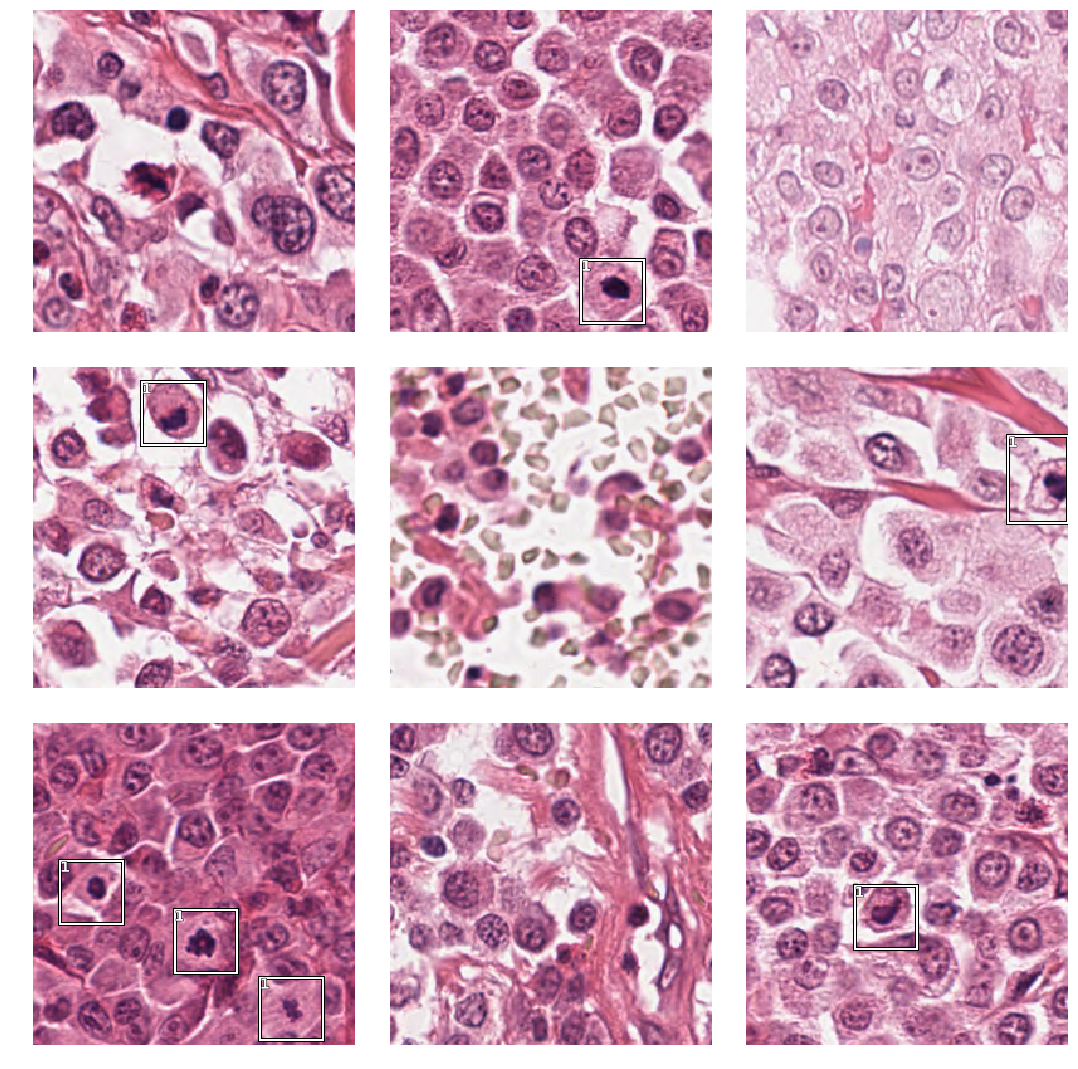

In [9]:
data.show_batch(rows=3, ds_type=DatasetType.Train, figsize=(15,15))

In [10]:
anchors = create_anchors(sizes=[(16,16)], ratios=[1], scales=[0.6, 0.7,0.8])


/usr/lib/python3/dist-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


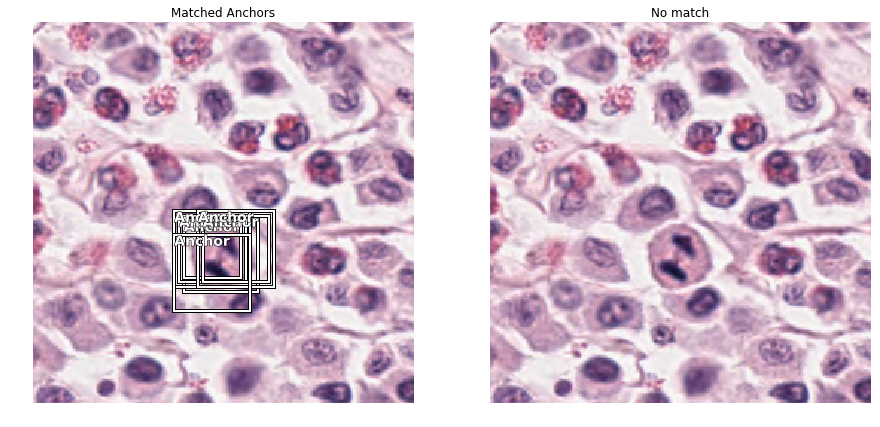

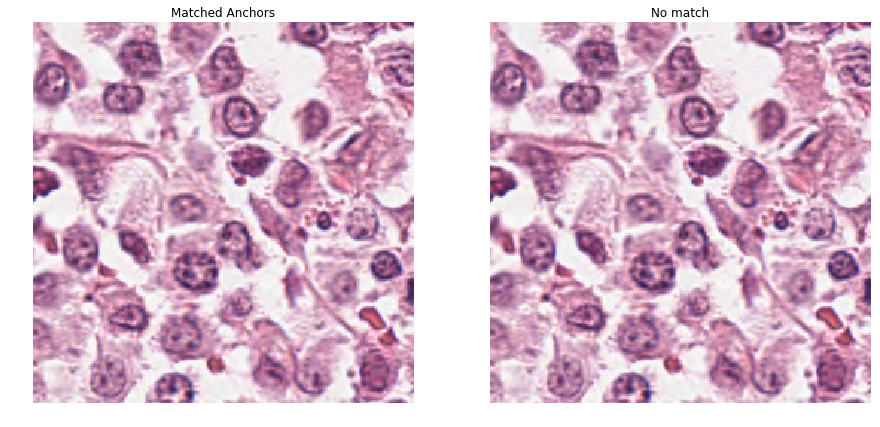

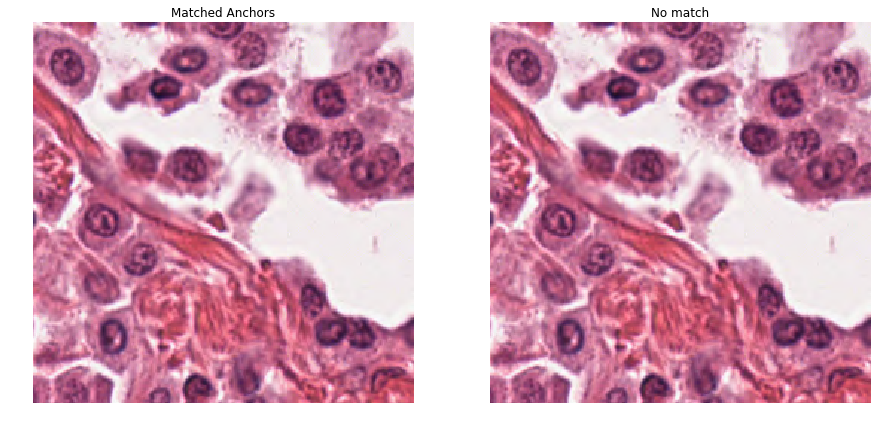

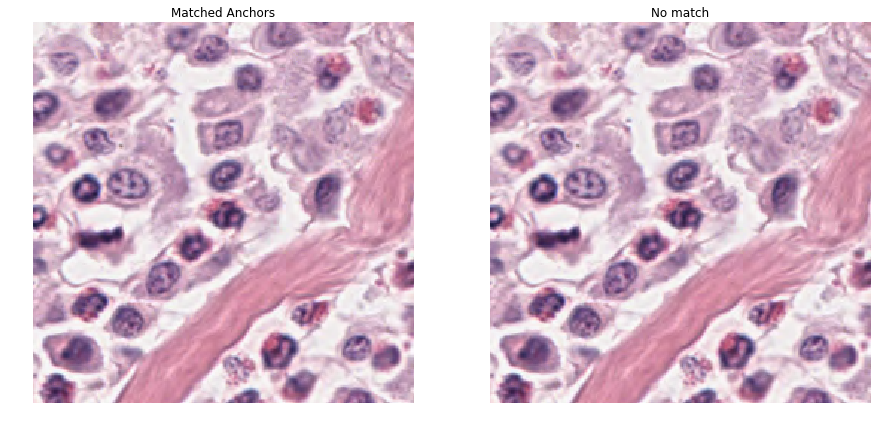

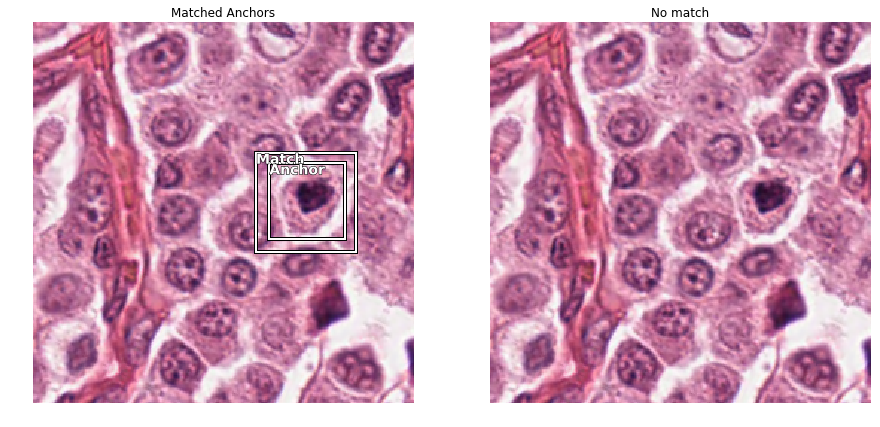

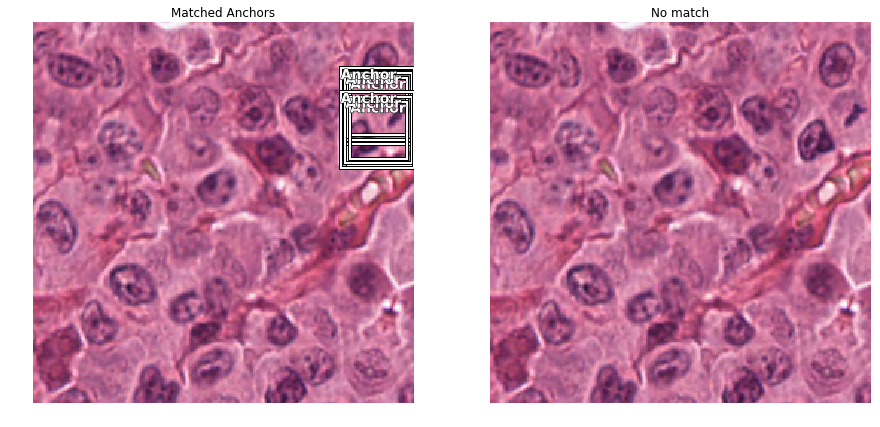

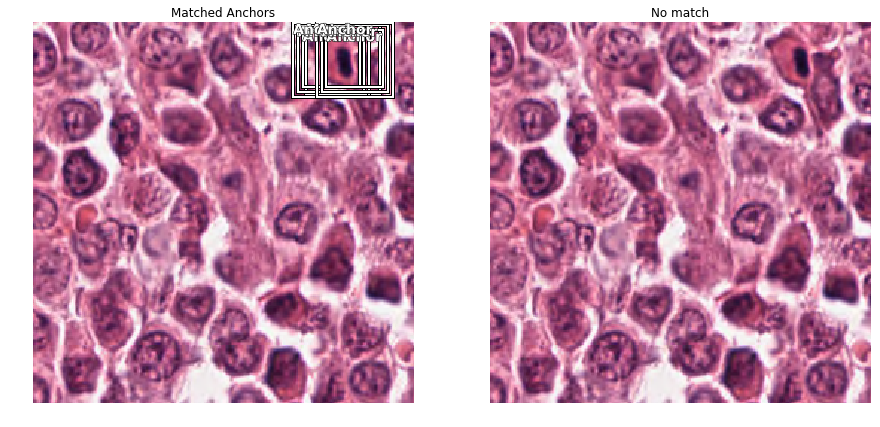

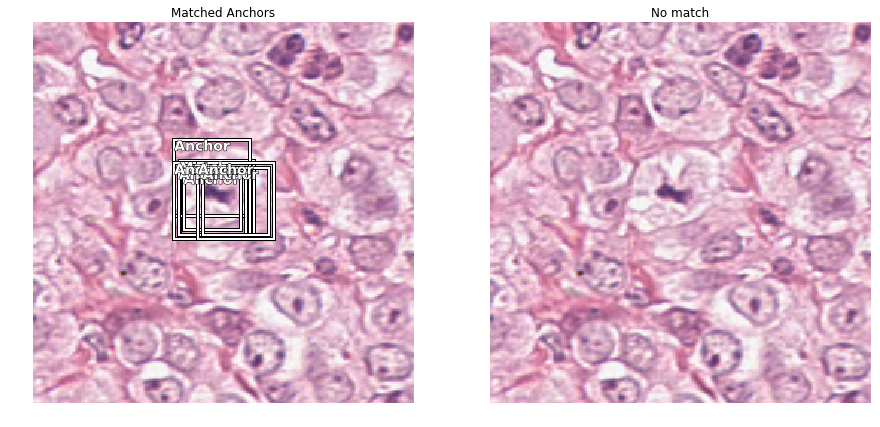

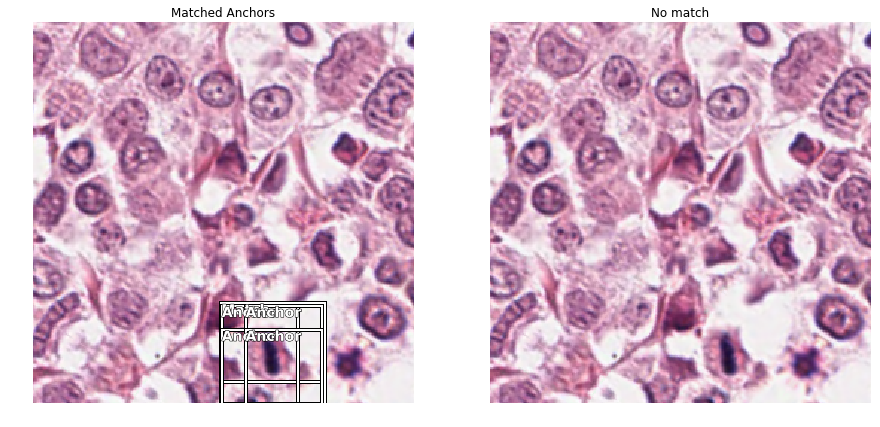

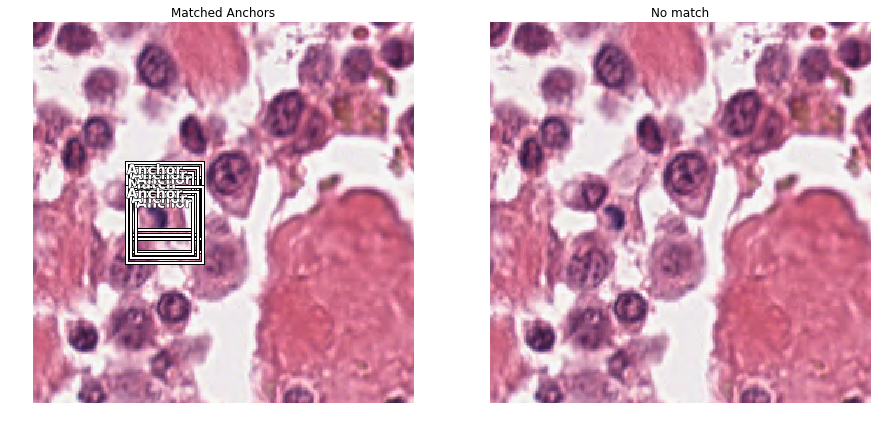

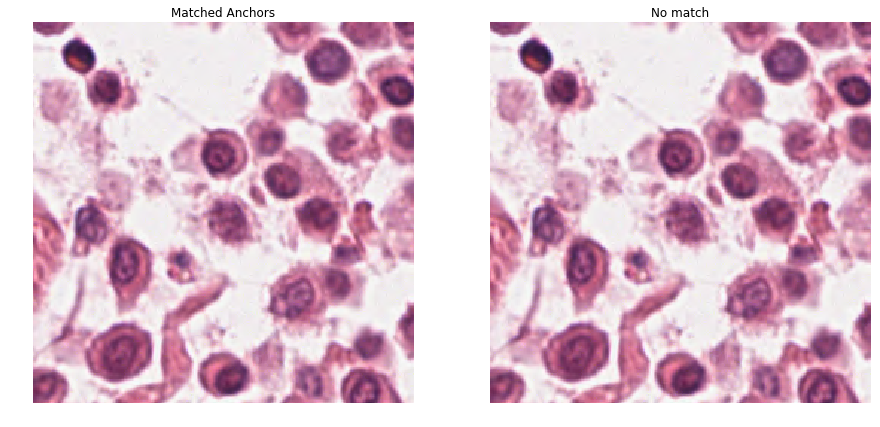

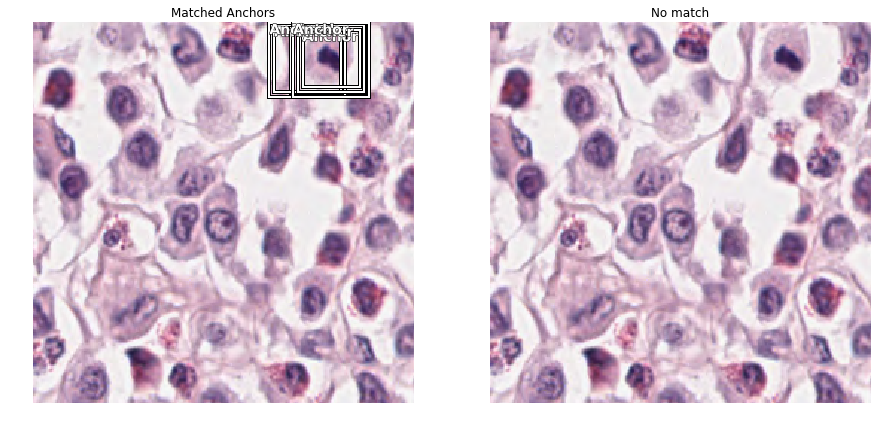

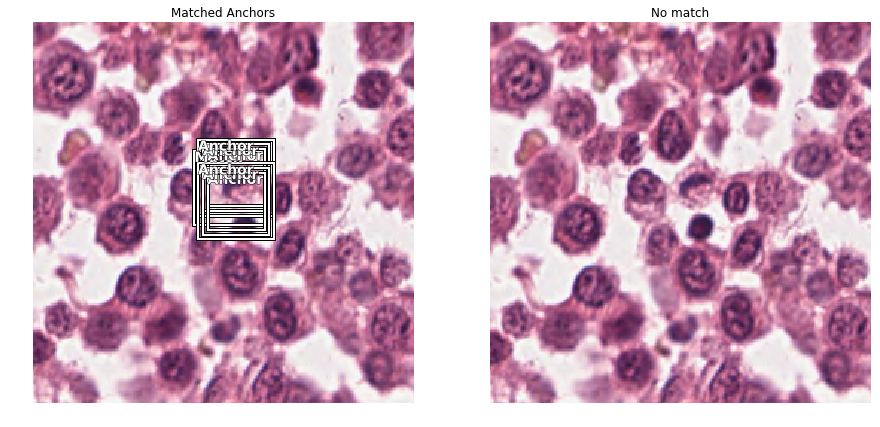

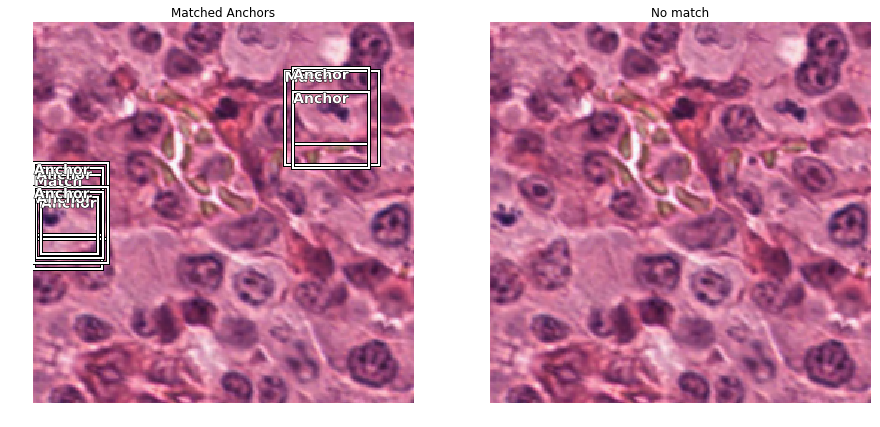

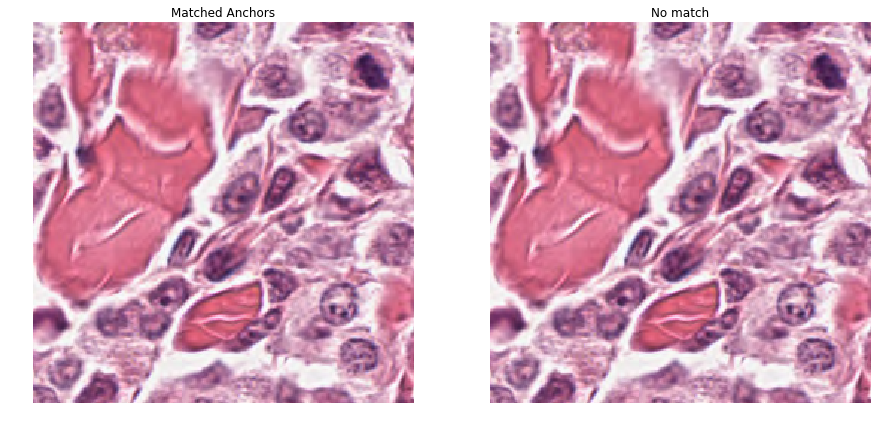

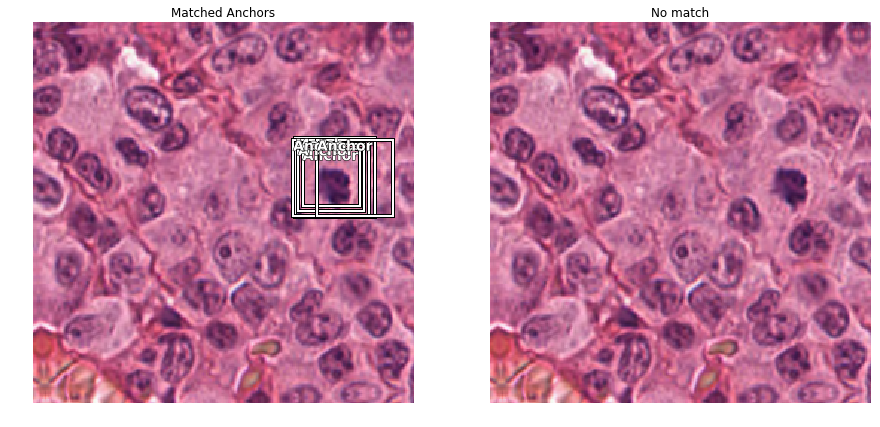

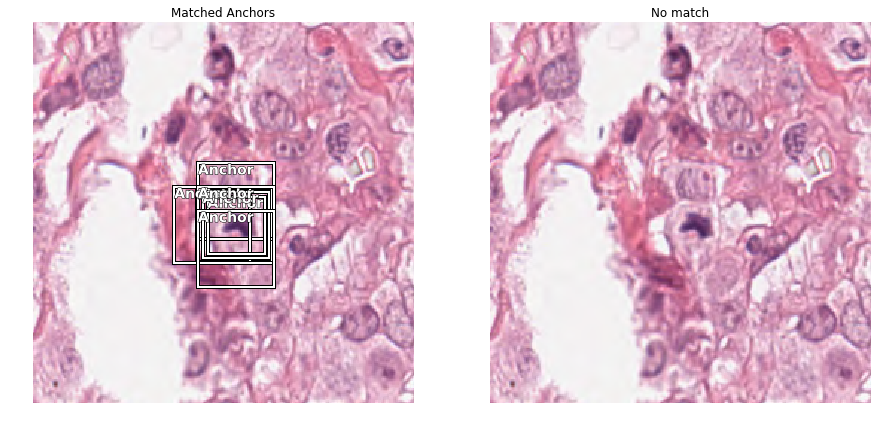

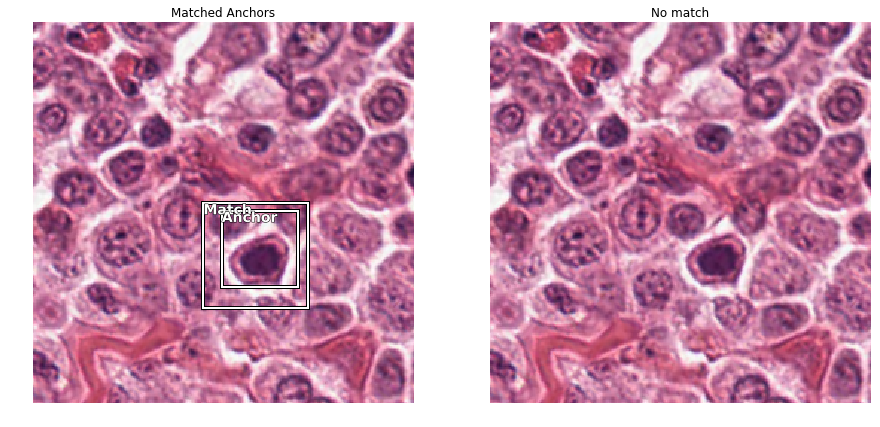

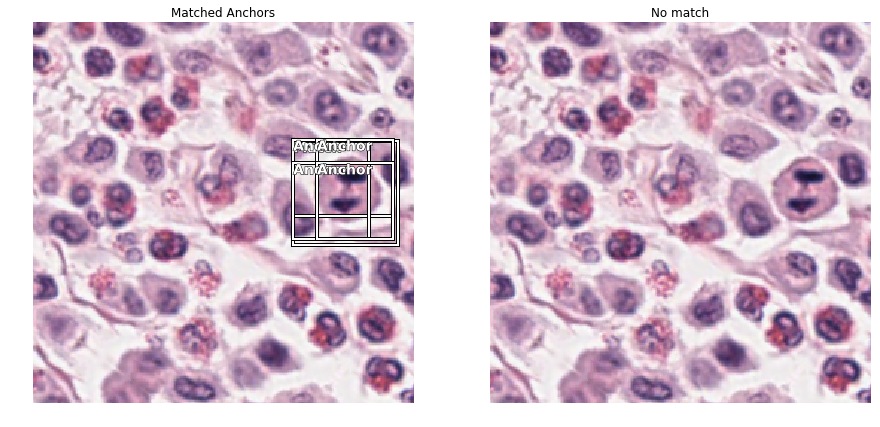

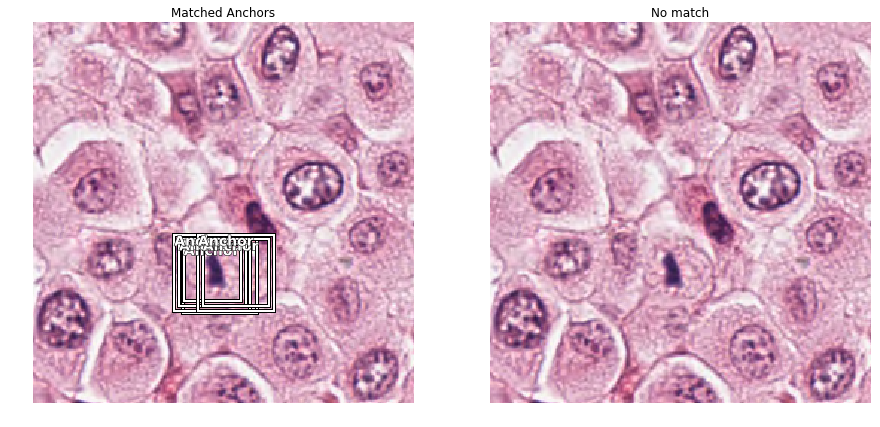

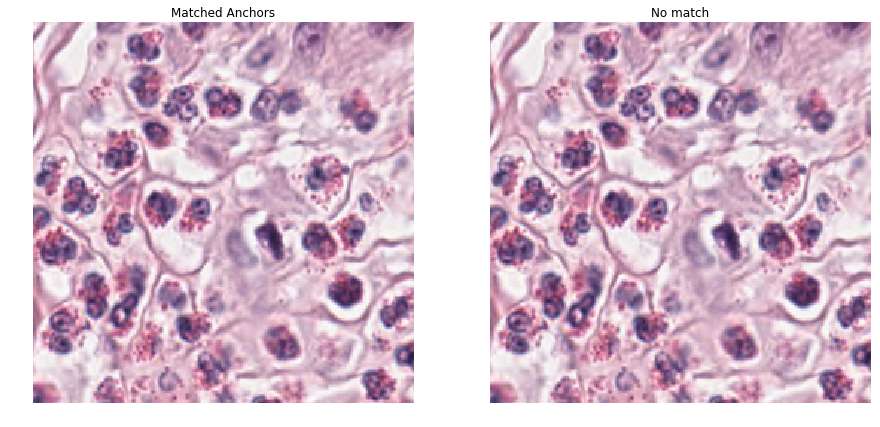

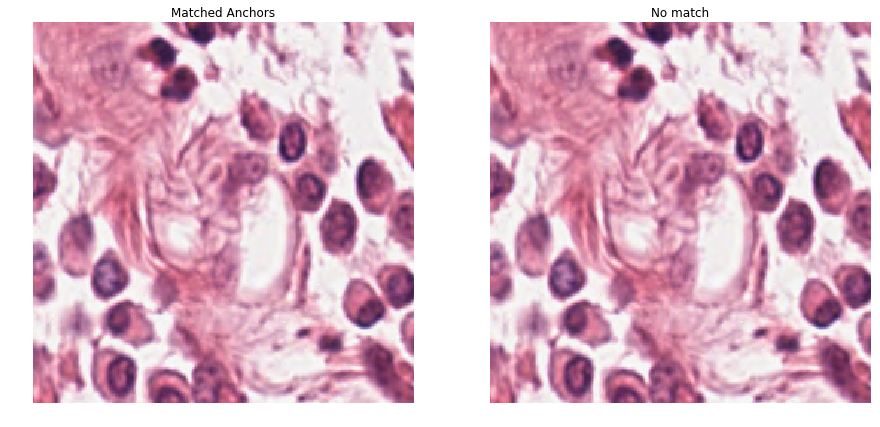

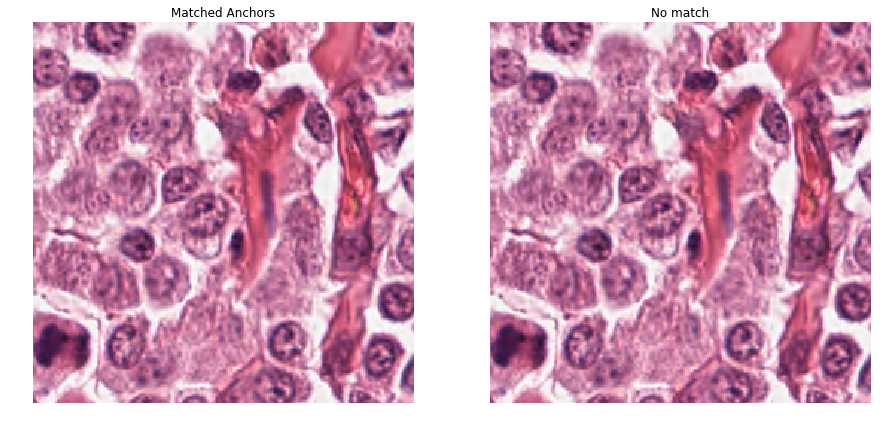

In [11]:
not_found = show_anchors_on_images(data, anchors)

In [12]:
crit = RetinaNetFocalLoss(anchors)

In [13]:
encoder = create_body(models.resnet18, True, -2)
model = RetinaNet(encoder, n_classes=data.train_ds.c, n_anchors=3, sizes=[16], chs=128, final_bias=-4., n_conv=3)



In [14]:
voc = PascalVOCMetric(anchors, size, [str(i-1) for i in data.train_ds.y.classes[1:]])
learn = Learner(data, model, loss_func=crit, callback_fns=[BBMetrics, ShowGraph], #BBMetrics, ShowGraph
                metrics=[voc]
               )

In [15]:
learn.split([model.encoder[6], model.c5top5])
learn.freeze_to(-2)


Run learning rate finder

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


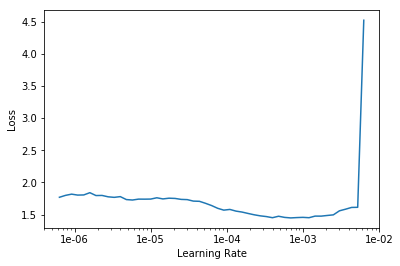

In [16]:
learn.lr_find()
learn.recorder.plot()

GT: 100%|██████████| 1713/1713 [00:00<00:00, 5667.17it/s]


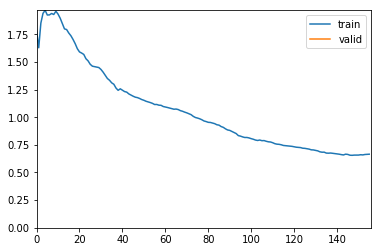

In [17]:
learn.fit_one_cycle(1, 1e-4)

GT: 100%|██████████| 2121/2121 [00:00<00:00, 4736.89it/s]


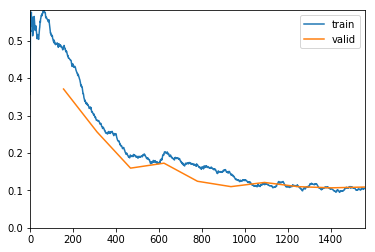

GT: 100%|██████████| 2162/2162 [00:00<00:00, 5183.17it/s]


In [18]:
lr=1e-4
learn.unfreeze()

learn.fit_one_cycle(10, lr)#, callbacks=[SaveModelCallback(learn, every='improvement', monitor='AP-0', name='model')])

In [19]:
lr=1e-4

#for k in range(3):
#    learn.fit_one_cycle(10, lr)

GT: 100%|██████████| 2220/2220 [00:00<00:00, 4255.56it/s]


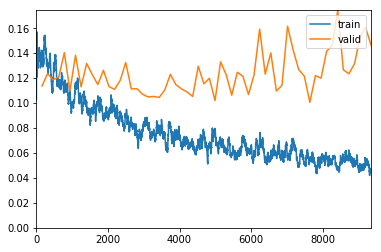

Better model found at epoch 0 with AP-0 value: 0.7221048720831058.


GT: 100%|██████████| 2146/2146 [00:00<00:00, 5066.15it/s]


Better model found at epoch 1 with AP-0 value: 0.7395573762976995.


GT: 100%|██████████| 2174/2174 [00:00<00:00, 5383.29it/s]


Better model found at epoch 2 with AP-0 value: 0.7905336718905268.


GT: 100%|██████████| 2128/2128 [00:00<00:00, 5521.74it/s]


Better model found at epoch 4 with AP-0 value: 0.8192325633489661.


GT: 100%|██████████| 2103/2103 [00:00<00:00, 5369.97it/s]


Better model found at epoch 6 with AP-0 value: 0.8244650882408397.


GT: 100%|██████████| 2166/2166 [00:00<00:00, 5246.37it/s]


Better model found at epoch 7 with AP-0 value: 0.8280750567041917.


GT: 100%|██████████| 2139/2139 [00:00<00:00, 5373.36it/s]


Better model found at epoch 15 with AP-0 value: 0.8288003751535632.


GT: 100%|██████████| 2121/2121 [00:00<00:00, 4038.59it/s]


Better model found at epoch 18 with AP-0 value: 0.831709739088566.


GT: 100%|██████████| 2134/2134 [00:00<00:00, 4737.05it/s]


Better model found at epoch 24 with AP-0 value: 0.8318171775715362.


GT: 100%|██████████| 2147/2147 [00:00<00:00, 4566.28it/s]


Better model found at epoch 27 with AP-0 value: 0.8406859143710599.


GT: 100%|██████████| 2162/2162 [00:00<00:00, 5426.22it/s]


Better model found at epoch 32 with AP-0 value: 0.8449119050014134.


GT: 100%|██████████| 2075/2075 [00:00<00:00, 5726.04it/s]


Better model found at epoch 39 with AP-0 value: 0.8638083207043739.


GT: 100%|██████████| 2158/2158 [00:00<00:00, 5549.36it/s]


In [20]:
learn.unfreeze()
lr=1e-4

learn.fit(60, lr, callbacks=[SaveModelCallback(learn, every='improvement', monitor='AP-0', name='model')])

In [21]:
#learn.save('RetinaNet-ODAEL-small-ave-2.pth', with_opt=True) 
#learn.fit(30, lr, callbacks=[SaveModelCallback(learn, every='improvement', monitor='AP-0', name='model')])

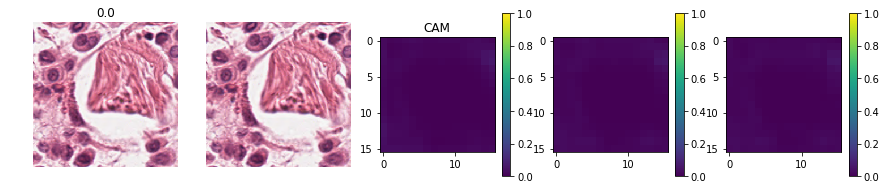

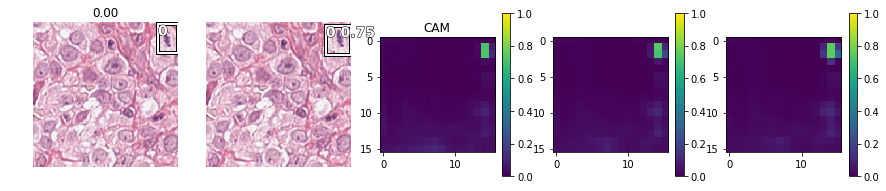

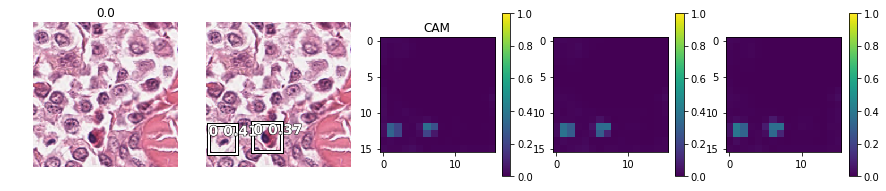

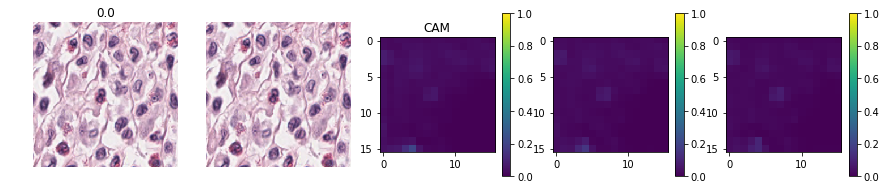

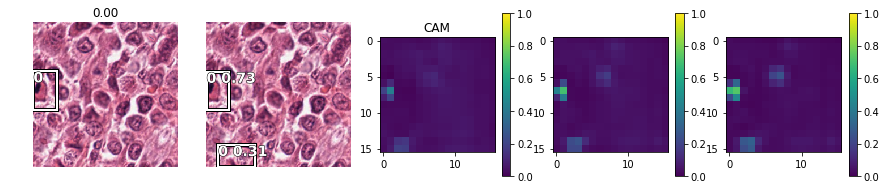

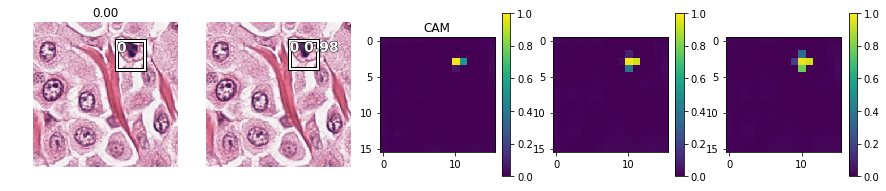

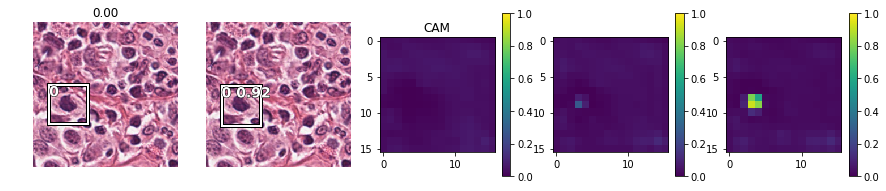

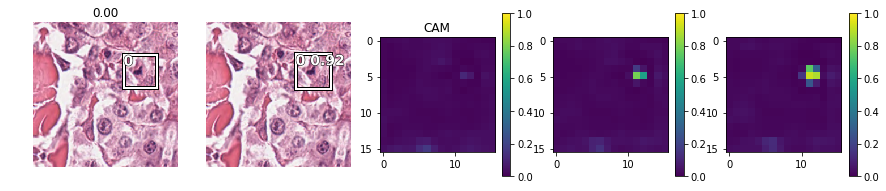

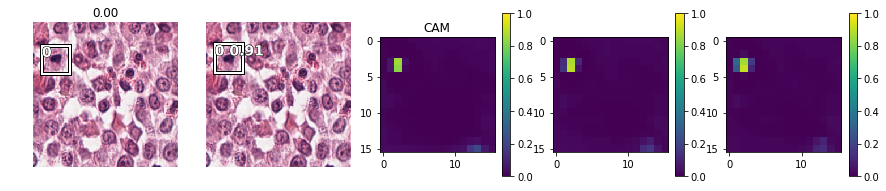

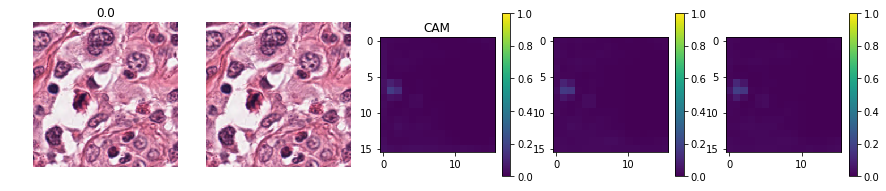

In [22]:
slide_object_result(learn, anchors, detect_thresh=0.3, nms_thresh=0.2, image_count=10)

In [23]:
learn.save('RetinaNe-ODAEL-small-save.pth', with_opt=True)
learn.export("RetinaNet-ODAEL-small-export.pth")